In [7]:
import os
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import nglui.statebuilder as ngstbld

# # this is the EM specific package for querying the EM data
from caveclient import CAVEclient

import scipy
from sklearn.decomposition import PCA
from numpy.random import default_rng

import umap

# from meshparty import trimesh_io, trimesh_vtk
# from meshparty import skeletonize, skeleton_io, skeleton
# import cloudvolume

%load_ext autoreload
%autoreload 2

query timestamp: 2024-01-17 08:10:01.179472-08:00 (1705507801.179472)
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [9]:
# client = CAVEclient()

# # if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
# client.auth.get_new_token(open=True)

In [10]:
# if you have not yet setup this computer, uncomment this below line
# paste the token from the website in, and run the line

# client.auth.save_token(token="c14cd7a3e18a1a697716a399afbf5778", overwrite=True)

# then comment or delete the line as you don't need to run it on this computer  again

# Load Motor neuron table

In [11]:
# pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='matched_typed_with_nt')
pre_to_mn_df = pd.read_pickle('./dfs_pre_to_mn/pre_to_mn_df_matched_typed_with_nt_v840.pkl')
pre_to_mn_df.shape
pre_to_mn_df.sum(axis=0).sum()

212190

In [21]:
pre_to_mn_df

side                                                                                                                                             L  \
nerve                                                                                                                                       Dorsal   
segment                                                                                                                                     thorax   
function                                                                                                                                     swing   
muscle                                                                                         tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                                             0   
segID                                                                                                                           648518346487756866   
module                                                                                                                                coxa_promote   
cell_class preferred_pool          NT   classification_system cell_type     segID                                                                    
descending coxa_promote            NaN  NaN                   NaN           648518346493883193                                                  0    
                                                                            648518346497743463                                                  0    
                                                                            648518346494476087                                                  0    
                                                                            648518346507377529                                                  0    
                                                                            648518346494232199                                                  0    
...                                                                                                                                            ...   
local      ltm_B                   GABA 19A                   19A_mid       648518346504149710                                                  0    
                                        09A                   09A           648518346490340104                                                  0    
                                   Ach  22A                   22A_posterior 648518346521544953                                                  0    
           tarsus_depress_medial   GABA 12B                   12B           648518346484940957                                                  0    
           tarsus_depress_ventralU Ach  03A                   03A           648518346491766952                                                  0    

side                                                                                                               \
nerve                                                                                                               
segment                                                                                                             
function                                                                                                            
muscle                                                                                                              
rank                                                                                                                
segID                                                                                          648518346491659326   
module                                                                                               coxa_promote   
cell_class preferred_pool          NT   classification_system c

## Divide up T1 by volume

In [22]:
from itertools import product

d = 10           # divide space by 5 um

x1 = 3400       # pixels
x2 = 50000
y1 = 80000      # pixels
y2 = 120000
z1 = 809        # pixels
z2 = 4000

d_convert = [4.3, 4.3, 45]

voxel_d_dict = {}
convert_loc_to_bin_dict = {}
convert_loc_to_bin_tup_dict = {}

voxel_d =  [2.5, 5, 7, 7.5, 8, 10, 15, 20]
# voxel_d =  [8]
for d in voxel_d: # loop over different edge lengths
    def convert_loc_to_um(df_l):
        bn_xyz = np.floor(np.array(df_l)*np.array(d_convert)/1000)
        return bn_xyz

    def convert_loc_to_bin(df_l):
        bn_xyz = d*np.floor(np.array(df_l)*np.array(d_convert)/1000/d)
        return bn_xyz.astype(float)

    def convert_loc_to_bin_tup(df_l):
        bn_xyz = d*np.floor(np.array(df_l)*np.array(d_convert)/1000/d)
        return tuple(bn_xyz.astype(float))

    # Make an index vector that divides up T1
    b1 = convert_loc_to_bin([x1,y1,z1])
    b2 = convert_loc_to_bin([x2,y2,z2])
    print(b1,b2)


    # All possible N combination tuples
    # Using list comprehension + product()
    x = np.linspace(b1[0], b2[0],num=((b2[0]+d-b1[0])/d).astype(int))
    y = np.linspace(b1[1], b2[1],num=((b2[1]+d-b1[1])/d).astype(int))
    z = np.linspace(b1[2], b2[2],num=((b2[2]+d-b1[2])/d).astype(int))

    # put z first so that contiguous bins are in x,y
    idx_tups = [ele for ele in product(x,y,z, repeat = 1)]

    len(idx_tups)
    syn_bin_df = pd.DataFrame(columns=pre_to_mn_df.columns, index=idx_tups)
    syn_bin_df.fillna(0, inplace=True)
    syn_bin_df.shape

    voxel_d_dict[d] = syn_bin_df
    convert_loc_to_bin_dict[d] = convert_loc_to_bin
    convert_loc_to_bin_tup_dict[d] = convert_loc_to_bin_tup
    
    syn_bin_df.columns = syn_bin_df.columns.get_level_values('segID')

#(160, 420, 140
#(190, 480, 100)
# (10, 430, 170)
# 10, 430, 170

[ 12.5 342.5  35. ] [215. 515. 180.]
[ 10. 340.  35.] [215. 515. 180.]
[ 14. 343.  35.] [210. 511. 175.]
[  7.5 337.5  30. ] [210. 510. 180.]
[  8. 344.  32.] [208. 512. 176.]
[ 10. 340.  30.] [210. 510. 180.]
[  0. 330.  30.] [210. 510. 180.]
[  0. 340.  20.] [200. 500. 180.]


In [23]:
syn_bin_df

segID,648518346487756866,648518346491659326,648518346517437482,648518346479446972,648518346479325585,648518346487504531,648518346478125293,648518346479077839,648518346489934387,648518346490738941,...,648518346486352776,648518346510155558,648518346507319880,648518346486212804,648518346491158817,648518346486890393,648518346480904925,648518346489767549,648518346495467855,648518346511950704
"(0.0, 340.0, 20.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0.0, 340.0, 40.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0.0, 340.0, 60.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0.0, 340.0, 80.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0.0, 340.0, 100.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(200.0, 500.0, 100.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(200.0, 500.0, 120.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(200.0, 500.0, 140.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(200.0, 500.0, 160.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
import utils

mnmi_df = pre_to_mn_df.columns.to_frame()
mnmi_df['preferred_pool'] = ''
mnmi_df['pref_pool_num'] = 0
mnmi_df
# make the preferred pool index
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_pools_coxa_ab() 

key_cnt = 0
for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    
    mnmi_df.loc[mn_tup,'preferred_pool'] = key
    mnmi_df.loc[mn_tup,'pref_pool_num'] = key_cnt

    key_cnt+=1

# mnmi_df.preferred_pool = mnmi_df.preferred_pool.astype("category")
# mnmi_df.preferred_pool = mnmi_df.preferred_pool.cat.set_categories(pool_keys)

# mnmi_df.sort_values(["preferred_pool"])
# mnmi_df = mnmi_df[['pref_pool_num','preferred_pool','segID']]
mnmi_df = mnmi_df.reset_index(drop=True)

# Run over MNs

In [25]:
soma_table = client.materialize.query_table('somas_dec2022',timestamp=connectome_create.get_timestamp())
soma_table.index = soma_table.pt_root_id

In [26]:
# test_df = client.materialize.synapse_query(post_ids = [648518346510034470], synapse_table = 'synapses_nov2022')
# print(test_df.shape)

In [27]:
# client.materialize.synapse_query(post_ids = 648518346493836024) # Takes list
# connectome_create.get_timestamp()

In [29]:
sx = [-3000, 3000]
sy = [-3000, 3000]
sz = [-300, 300]

mn_cnt = 0
for mnid in syn_bin_df.columns.get_level_values('segID'):
    print('{}: {}'.format(mn_cnt,mnid))

    # make a box around the soma to get rid of any synapses there.
    s=soma_table.loc[mnid,:].pt_position
    nearsoma = lambda b: (b[0]>=s[0]+sx[0]) & (b[0]<=s[0]+sx[1]) & (b[1]>=s[1]+sy[0]) & (b[1]<=s[1]+sy[1]) & (b[2]>=s[2]+sz[0]) & (b[2]<=s[2]+sz[1])

    mn_inputs_df = client.materialize.synapse_query(post_ids = mnid,timestamp=connectome_create.get_timestamp()) # Takes list
    for d in voxel_d:
        synbins = mn_inputs_df.post_pt_position.apply(convert_loc_to_bin_tup_dict[d])
        syn_bin_df = voxel_d_dict[d]
        print('   {}: {} synapses'.format(d,len(synbins)))

        # This eliminates any synapses that are near the soma
        in_soma_box = synbins.apply(nearsoma)
        
        synbins = synbins.loc[~in_soma_box]
        for syn in synbins:
            syn_bin_df.loc[[syn],mnid]+=1

        voxel_d_dict[d] = syn_bin_df
        
    mn_cnt+=1

0: 648518346487756866
   2.5: 2021 synapses
   5: 2021 synapses
   7: 2021 synapses
   7.5: 2021 synapses
   8: 2021 synapses
   10: 2021 synapses
   15: 2021 synapses
   20: 2021 synapses
1: 648518346491659326
   2.5: 5198 synapses
   5: 5198 synapses
   7: 5198 synapses
   7.5: 5198 synapses
   8: 5198 synapses
   10: 5198 synapses
   15: 5198 synapses
   20: 5198 synapses
2: 648518346517437482
   2.5: 5119 synapses
   5: 5119 synapses
   7: 5119 synapses
   7.5: 5119 synapses
   8: 5119 synapses
   10: 5119 synapses
   15: 5119 synapses
   20: 5119 synapses
3: 648518346479446972
   2.5: 7939 synapses
   5: 7939 synapses
   7: 7939 synapses
   7.5: 7939 synapses
   8: 7939 synapses
   10: 7939 synapses
   15: 7939 synapses
   20: 7939 synapses
4: 648518346479325585
   2.5: 7950 synapses
   5: 7950 synapses
   7: 7950 synapses
   7.5: 7950 synapses
   8: 7950 synapses
   10: 7950 synapses
   15: 7950 synapses
   20: 7950 synapses
5: 648518346487504531
   2.5: 8992 synapses
   5: 8992 

In [30]:
# get rid of any rows (voxels) that have no synapses
for d in voxel_d:
    syn_bin_df = voxel_d_dict[d]
    syn_bin_df = syn_bin_df.loc[syn_bin_df.sum(axis=1)>0]
    voxel_d_dict[d] = syn_bin_df

In [31]:
# save the different dataframes
for d in voxel_d:
    syn_bin_df = voxel_d_dict[d]
    utils.save_df_as_pickle(syn_bin_df,name='syn_bin_df_{}um'.format(d))

./dfs_saved/syn_bin_df_2.5um_20240627.pkl
(28899, 69)
./dfs_saved/syn_bin_df_5um_20240627.pkl
(5879, 69)
./dfs_saved/syn_bin_df_7um_20240627.pkl
(2637, 69)
./dfs_saved/syn_bin_df_7.5um_20240627.pkl
(2241, 69)
./dfs_saved/syn_bin_df_8um_20240627.pkl
(1892, 69)
./dfs_saved/syn_bin_df_10um_20240627.pkl
(1122, 69)
./dfs_saved/syn_bin_df_15um_20240627.pkl
(433, 69)
./dfs_saved/syn_bin_df_20um_20240627.pkl
(221, 69)


# Load syn_bins

In [33]:
# Will have to transpose the matrix, to get MNs as rows, with syn densities as attributes
# for now, remove rows with no postive integers
voxel_d_import_dict = {}
# voxel_d = [2.5, 5, 7, 7.5, 8, 10, 15, 20]
for d in voxel_d:
# for d in [7.5]:
    syn_bin_df = pd.read_pickle('./dfs_saved/syn_bin_df_{}um_20240627.pkl'.format(d))
    syn_bin_df = syn_bin_df.loc[syn_bin_df.sum(axis=1)>0,:]
    voxel_d_import_dict[d] = syn_bin_df

# Show the syn_bin_dfs

In [34]:
d = 8
syn_bin_df = voxel_d_import_dict[d]

In [35]:
voxel_d_import_dict

{2.5: segID                  648518346487756866  648518346491659326  \
 (17.5, 435.0, 170.0)                    0                   0   
 (22.5, 435.0, 132.5)                    0                   0   
 (22.5, 435.0, 160.0)                    0                   0   
 (22.5, 435.0, 167.5)                    0                   0   
 (22.5, 437.5, 142.5)                    0                   0   
 ...                                   ...                 ...   
 (202.5, 472.5, 112.5)                   0                   0   
 (202.5, 477.5, 110.0)                   0                   0   
 (205.0, 467.5, 115.0)                   0                   0   
 (205.0, 475.0, 110.0)                   0                   0   
 (205.0, 475.0, 112.5)                   0                   0   
 
 segID                  648518346517437482  648518346479446972  \
 (17.5, 435.0, 170.0)                    0                   0   
 (22.5, 435.0, 132.5)                    0                   0   
 (2

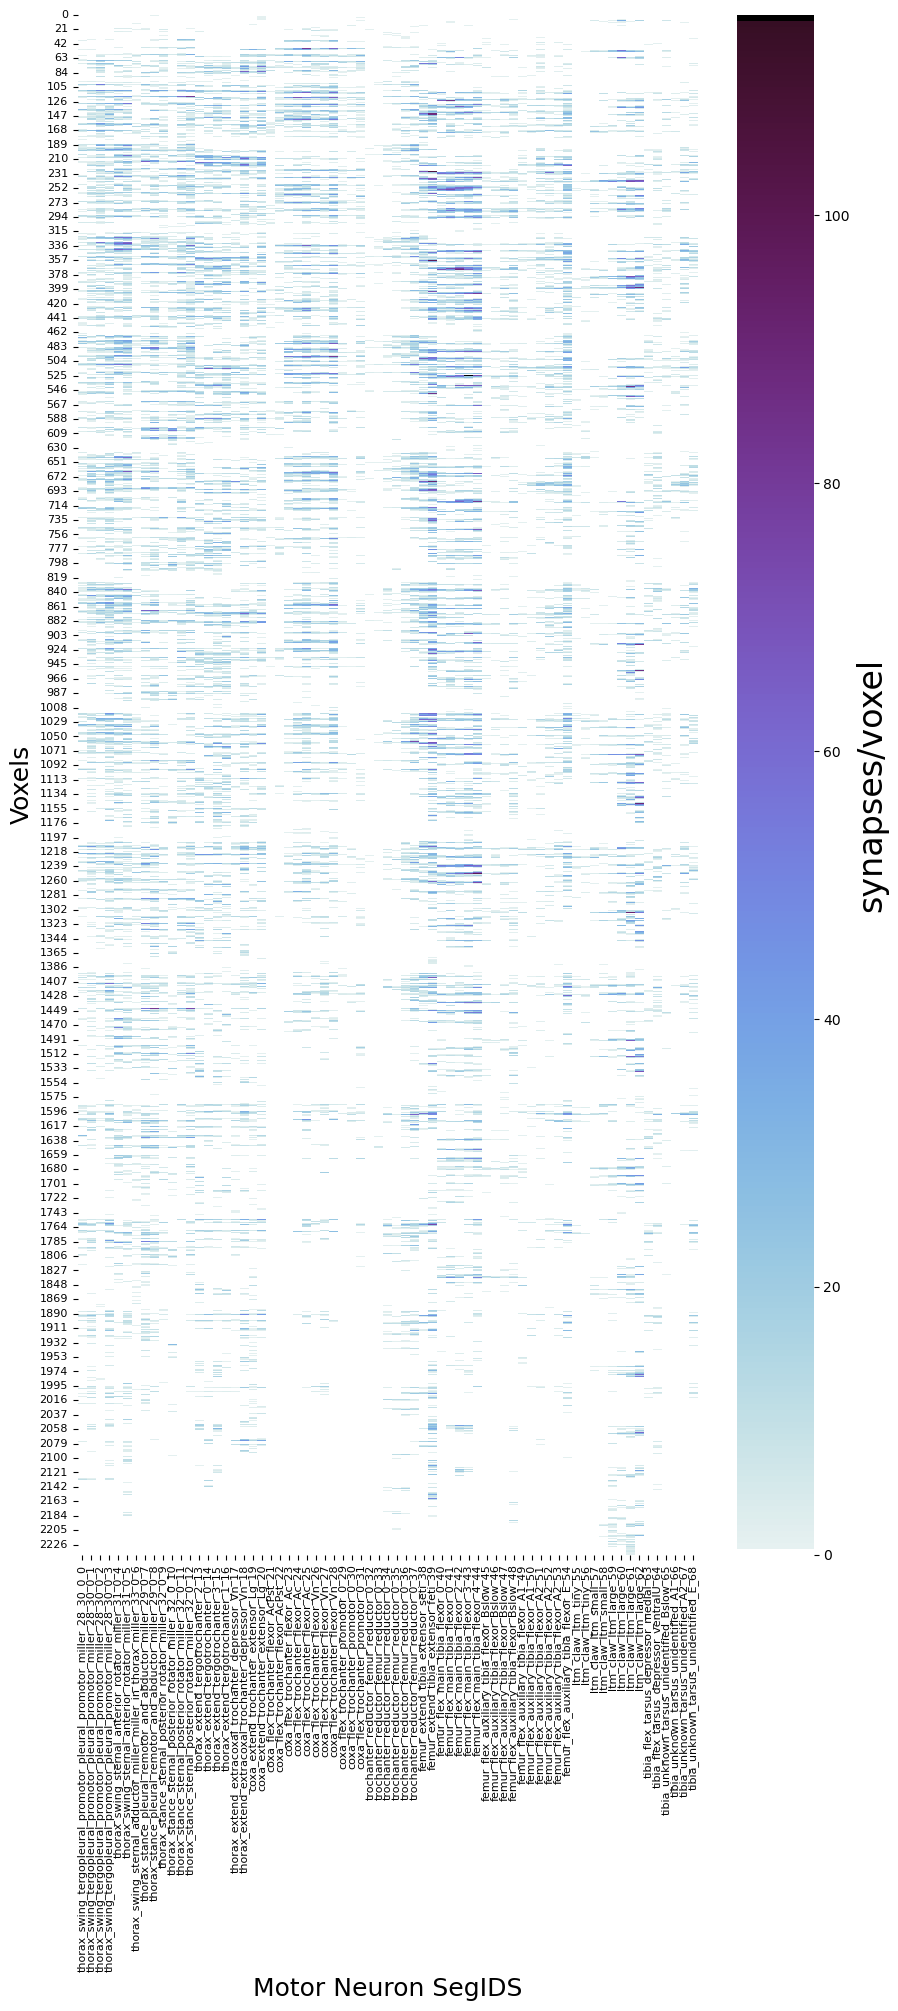

In [36]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

cmap = utils.white_dense()

mn_mi = pre_to_mn_df.columns.to_frame()
lbls = utils.mn_labels(mn_mi,depth='rank')

syn_bin_df = voxel_d_import_dict[7.5]

fig = plt.figure(1, figsize = [10,20])
ax = sns.heatmap(syn_bin_df.to_numpy(), xticklabels=lbls, cmap=cmap)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'synapses/voxel', size=24)
plt.xlabel('Motor Neuron SegIDS', fontsize =18)
plt.ylabel('Voxels', fontsize =18)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.show()

fig.savefig('syn_rho_xyz_mat_{}.eps'.format('7_5'),format='eps')

In [37]:
syn_bin_df


segID,648518346487756866,648518346491659326,648518346517437482,648518346479446972,648518346479325585,648518346487504531,648518346478125293,648518346479077839,648518346489934387,648518346490738941,...,648518346486352776,648518346510155558,648518346507319880,648518346486212804,648518346491158817,648518346486890393,648518346480904925,648518346489767549,648518346495467855,648518346511950704
"(15.0, 435.0, 165.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(22.5, 427.5, 127.5)",0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
"(22.5, 427.5, 142.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(22.5, 427.5, 150.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(22.5, 427.5, 157.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(195.0, 480.0, 105.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
"(195.0, 487.5, 105.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
"(202.5, 465.0, 112.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
"(202.5, 472.5, 105.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0


In [38]:
syn_bin_df.sum(axis=1).all()

True

# Choose a distance for the below

In [60]:
d = 8
syn_bin_df = voxel_d_import_dict[d]

# also zoom in on the central cluster
xlims_dict = {}
xlims_dict[2.5] = [9,14]
xlims_dict[5] = [2,6]
xlims_dict[7.5] = [4.5,7.5]
xlims_dict[8] = [4.5,8]
xlims_dict[10] = [-3,2]
xlims_dict[15] = [4,7]
xlims_dict[20] = [-7.5,-4.5]

ylims_dict = {}
ylims_dict[2.5] = [-5,0]
ylims_dict[5] = [10,15]
ylims_dict[7.5] = [7,10]
ylims_dict[8] = [2.5,5.2]
ylims_dict[10] = [0,3]
ylims_dict[15] = [-2,6]
ylims_dict[20] = [-2.5,2.5]

xlims = xlims_dict[d]
ylims = ylims_dict[d]


# Normalize
Interestingly, the L1 and L2 norms have different effects. Why?

In [61]:
syn_bin_L2_norm = syn_bin_df.copy()
syn_bin_L1_norm = syn_bin_df.copy()
for c in range(syn_bin_L2_norm.shape[1]):
    syn_bin_L2_norm.iloc[:,c] = syn_bin_L2_norm.iloc[:,c]/np.sqrt((syn_bin_L2_norm.iloc[:,c]**2).sum()) # L2 norm
    syn_bin_L1_norm.iloc[:,c] = syn_bin_L1_norm.iloc[:,c]/syn_bin_L1_norm.iloc[:,c].sum()

# Then run UMAP

(69, 2)


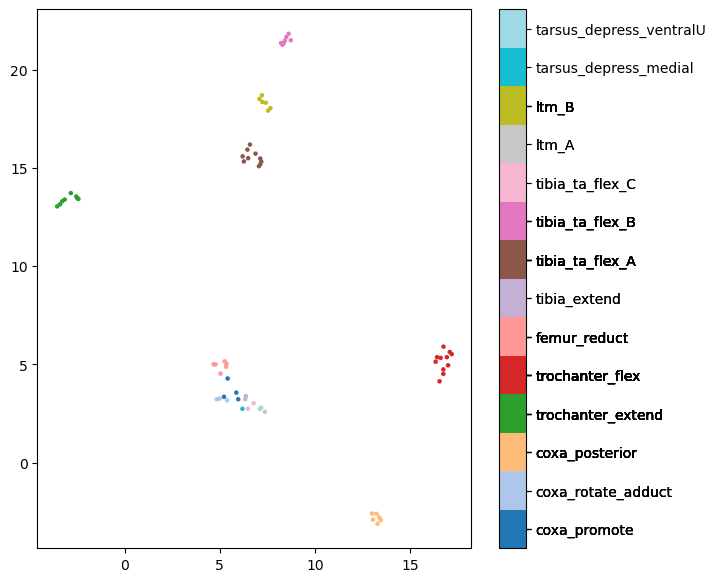

In [62]:
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=.2, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

reducer.fit(syn_bin_L2_norm.T)
embedding = reducer.transform(syn_bin_L2_norm.T)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
print(embedding.shape)


fig, ax = plt.subplots(1,1,figsize=(7,7))
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(projection='3d')
# sp = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c = mnmi_df.pref_pool_num.T, cmap='tab20', s=5)
sp = ax.scatter(embedding[:, 0], embedding[:, 1], c = mnmi_df.pref_pool_num.T, cmap='tab20', s=5)
colorbar = plt.colorbar(sp,boundaries=np.arange(15)-0.5)
colorbar.set_ticks(mnmi_df.pref_pool_num)
colorbar.set_ticklabels(mnmi_df.preferred_pool)



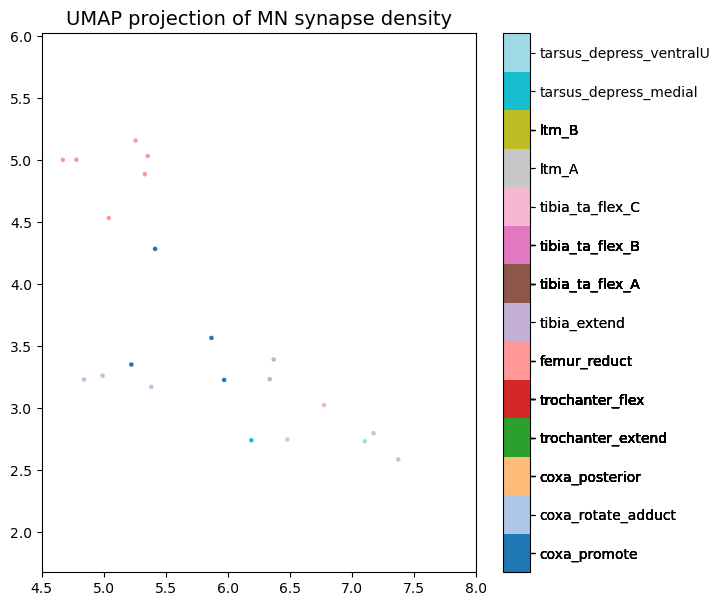

In [63]:
# mnmi_df = mnmi_df.reset_index(drop=True)


mnmi_df.loc['tibia_ta_flex_A',:].segID.to_list()

mnmi_df.loc['ltm_B',:]

fig, ax = plt.subplots(figsize=(7,7))
sp = ax.scatter(embedding[:, 0], embedding[:, 1], c = mnmi_df.pref_pool_num.T, cmap='tab20', s=5)
colorbar = plt.colorbar(sp,boundaries=np.arange(15)-0.5)
colorbar.set_ticks(mnmi_df.pref_pool_num)
colorbar.set_ticklabels(mnmi_df.preferred_pool)
ax.set_aspect('equal', 'datalim')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.title('UMAP projection of MN synapse density', fontsize=14);


fig.savefig('./figpanels/UMAP_syn_bin_closeup_{}um_bins.svg'.format(d),format='svg')

# Cosine Similarity

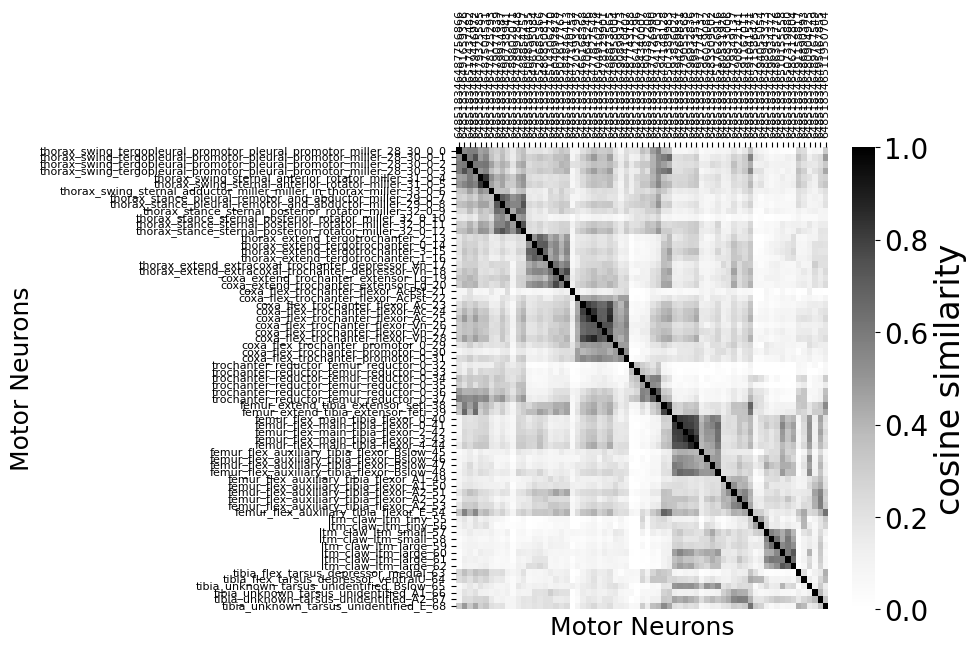

In [64]:
# Cluster according to everything but fragments
mn_mi = pre_to_mn_df.columns.to_frame()
lbls = utils.mn_labels(mn_mi,depth='rank')

d=8

syn_bin_df = voxel_d_import_dict[d]

sim_mat = cosine_similarity(syn_bin_df.to_numpy().transpose())
fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, xticklabels=mn_mi.segID.to_list(), yticklabels=lbls,cmap=plt.get_cmap('Greys'))
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.show()

fig.savefig('./figpanels/cos_sim_rho_grayscale.svg',format='svg')

# How does discriminability depend on d?

In [65]:
mn_mi = pre_to_mn_df.columns.to_frame()
lbls = utils.mn_labels(mn_mi,depth='rank')

sim_mat = cosine_similarity(syn_bin_df.to_numpy().transpose())

voxel_d_sim_mat = {}
for d in voxel_d:
    syn_bin_df = voxel_d_import_dict[d]
    voxel_d_sim_mat[d] = cosine_similarity(syn_bin_df.to_numpy().transpose())

## make a mask for within vs across pool comparison

In [68]:
import utils
mn_mi_df = pre_to_mn_df.columns.to_frame()
mn_mi_df

# Ha! for this, put the tarsus neurons in the right pools
muscle_tuple_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_morpho_pools()

for key in pool_keys:
    mn_tup = muscle_tuple_dict[key]
    mn_mi_df.loc[mn_tup,'preferred_pool'] = key

mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.astype("category")
mn_mi_df.preferred_pool = mn_mi_df.preferred_pool.cat.set_categories(pool_keys)
mn_mi_df

side  \
side nerve   segment function muscle                                             rank     segID              module                         
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866 coxa_promote               L   
                                                                                          648518346491659326 coxa_promote               L   
                                                                                          648518346517437482 coxa_promote               L   
                                                                                          648518346479446972 coxa_promote               L   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585 coxa_rotate_adduct         L   
...                                                                                                                                   ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393 tarsus_depress_ventralU    L   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925 tibia_ta_flex_A            L   
                                                                                 A1       648518346489767549 tibia_ta_flex_B            L   
                                                                                 A2       648518346495467855 tibia_ta_flex_B            L   
                                                                                 E        648518346511950704 tibia_ta_flex_C            L   

                                                                                                                                        nerve  \
side nerve   segment function muscle                                             rank     segID              module                             
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866 coxa_promote              Dorsal   
                                                                                          648518346491659326 coxa_promote              Dorsal   
                                                                                          648518346517437482 coxa_promote              Dorsal   
                                                                                          648518346479446972 coxa_promote              Dorsal   
     Ventral thorax  swing    sternal_anterior_rotator_miller_31                 0        648518346479325585 coxa_rotate_adduct       Ventral   
...                                                                                                                                       ...   
     Leg     tibia   flex     tarsus_depressor                                   ventralU 648518346486890393 tarsus_depress_ventralU      Leg   
                     unknown  tarsus_unidentified                                Bslow    648518346480904925 tibia_ta_flex_A              Leg   
                                                                                 A1       648518346489767549 tibia_ta_flex_B              Leg   
                                                                                 A2       648518346495467855 tibia_ta_flex_B              Leg   
                                                                                 E        648518346511950704 tibia_ta_flex_C              Leg   

                                                                                                                                     segment  \
side nerve   segment function muscle                                             rank     segID              module                            
L    Dorsal  thorax  swing    tergopleural_promotor_pleural_promotor_miller_2... 0        648518346487756866 coxa_promote    

array(['coxa_anterior', 'coxa_anterior', 'coxa_anterior', ...,
       'tibia_ta_flex_C', 'tibia_ta_flex_C', 'tibia_ta_flex_C'],
      dtype=object)

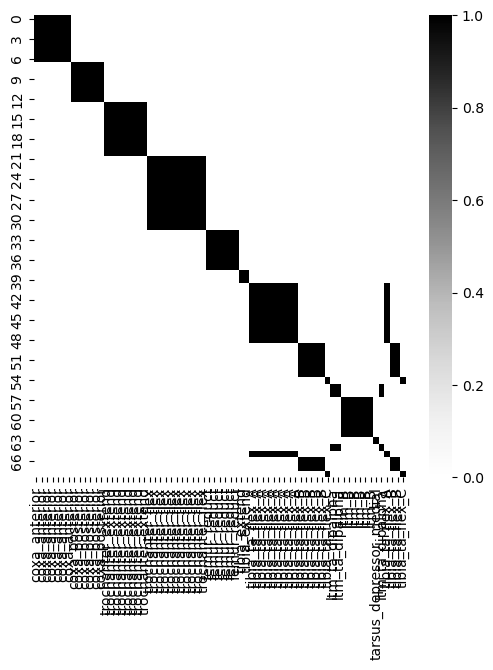

In [69]:
tril_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), True, dtype=bool)
motor_pool_mask = np.full((sim_mat.shape[0], sim_mat.shape[1]), False, dtype=bool)
i_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
j_index = np.full((sim_mat.shape[0], sim_mat.shape[1]), 0, dtype=int)
for i in range(motor_pool_mask.shape[0]):
    for j in range(motor_pool_mask.shape[1]):
        motor_pool_mask[i,j] =(mn_mi_df.iloc[i,:].preferred_pool==mn_mi_df.iloc[j,:].preferred_pool)
        i_index[i,j] = i
        j_index[i,j] = j

fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(motor_pool_mask, xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=plt.get_cmap('Greys'))

# fig = plt.figure(2, figsize = [6,6])
# ax = sns.heatmap(np.tril(motor_pool_mask,-1), xticklabels=mn_mi_df.preferred_pool.to_list(),cmap=plt.get_cmap('Greys'))

tril_mask = np.tril(tril_mask,-1)

pool_arr = mn_mi_df.preferred_pool.to_numpy()
pool_arr = np.tile(pool_arr.reshape((-1,1)),len(pool_arr))
pool_arr.reshape(-1)

In [70]:
tril_mask

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False]])

In [71]:
sim_dict = {
    'pool':pool_arr.reshape(-1),
    'same_pool': motor_pool_mask.reshape(-1),
    'lower_tri':tril_mask.reshape(-1),
    'i_index':i_index.reshape(-1),
    'j_index':j_index.reshape(-1)
    }


In [72]:
sim_compare_df = pd.DataFrame.from_dict(data = sim_dict,orient='columns')

for d in voxel_d:
    sim_compare_df['cos_sim_{}'.format(d)] = voxel_d_sim_mat[d].reshape(-1)
    
# # get rid of upper triangle
sim_compare_df = sim_compare_df.loc[sim_compare_df.lower_tri.to_numpy()]
sim_compare_df


,pool,same_pool,lower_tri,i_index,j_index,cos_sim_2.5,cos_sim_5,cos_sim_7,cos_sim_7.5,cos_sim_8,cos_sim_10,cos_sim_15,cos_sim_20
69,coxa_anterior,True,True,1,0,0.181819,0.378909,0.516173,0.546158,0.545085,0.642529,0.777911,0.838903
138,coxa_anterior,True,True,2,0,0.180600,0.356254,0.506010,0.506554,0.578534,0.610205,0.723018,0.821722
139,coxa_anterior,True,True,2,1,0.242285,0.441649,0.551046,0.594162,0.604201,0.668655,0.782742,0.860052
207,coxa_anterior,True,True,3,0,0.220820,0.405040,0.542097,0.567389,0.585437,0.665624,0.790764,0.862336
208,coxa_anterior,True,True,3,1,0.342258,0.589354,0.740370,0.751357,0.753651,0.822070,0.917123,0.959489
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,tibia_ta_flex_C,False,True,68,63,0.086868,0.245424,0.372091,0.399925,0.419169,0.514736,0.686191,0.757991
4756,tibia_ta_flex_C,False,True,68,64,0.049065,0.226465,0.334508,0.362428,0.384852,0.439669,0.620578,0.725324
4757,tibia_ta_flex_C,False,True,68,65,0.011153,0.070063,0.126686,0.129507,0.149404,0.203282,0.272932,0.355275
4758,tibia_ta_flex_C,False,True,68,66,0.036803,0.107283,0.154503,0.228284,0.184998,0.244012,0.420790,0.540781


In [73]:
voxel_d

[2.5, 5, 7, 7.5, 8, 10, 15, 20]

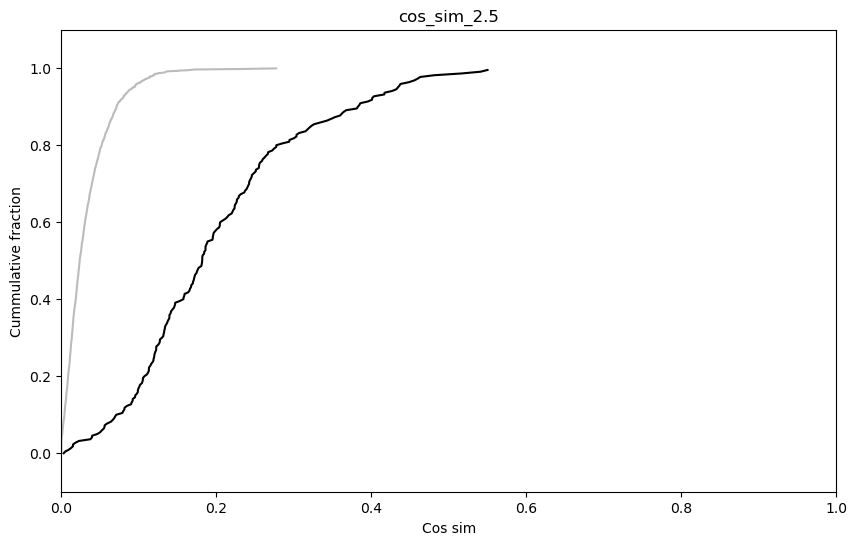

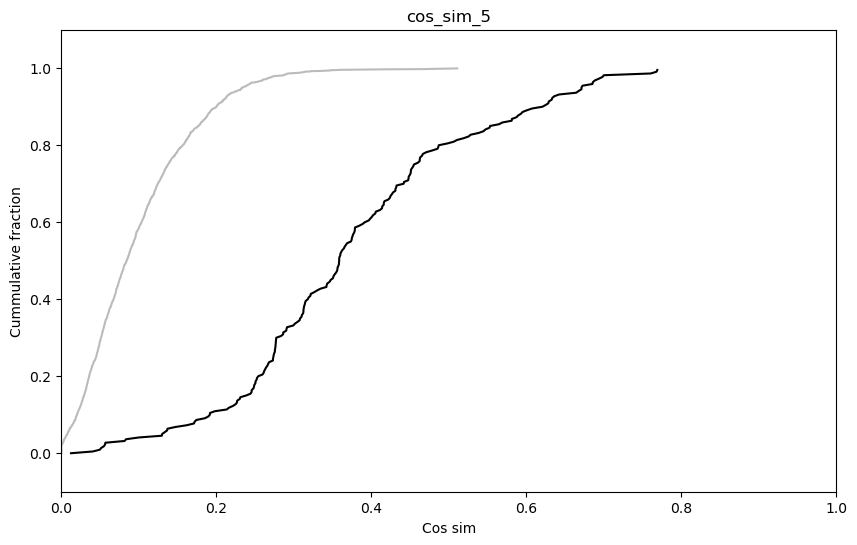

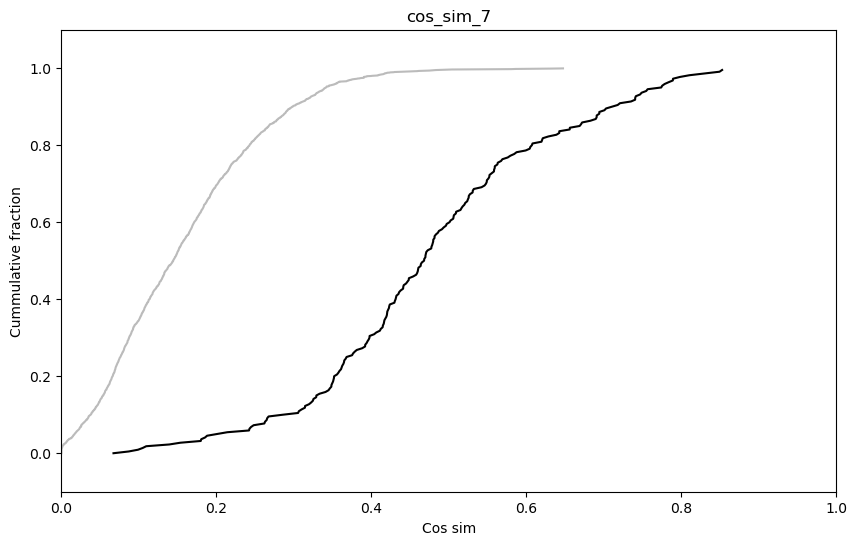

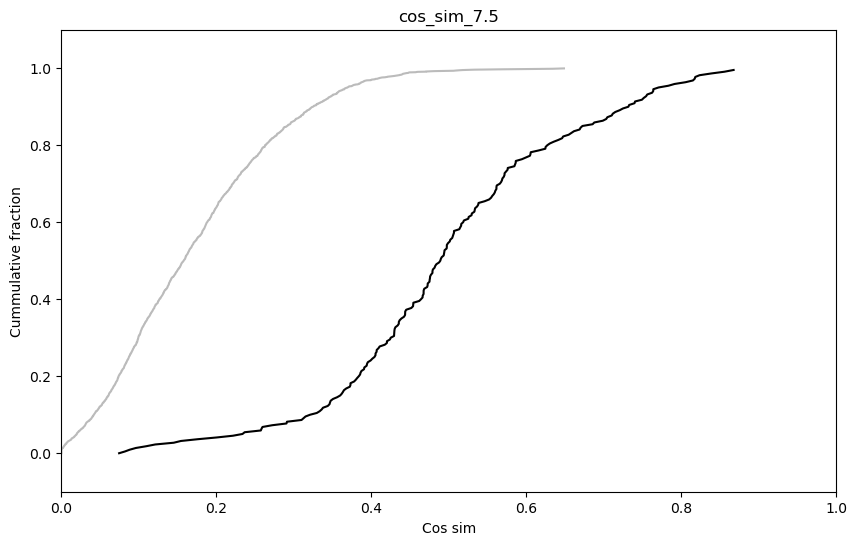

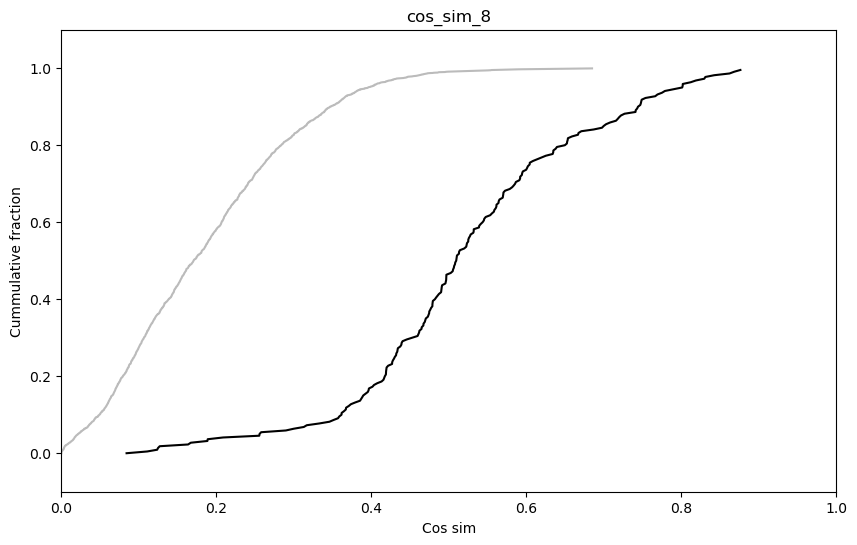

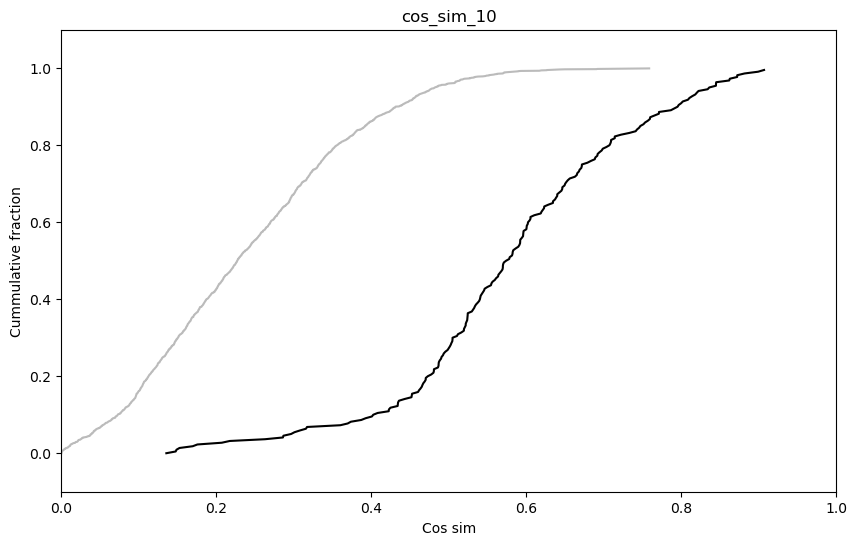

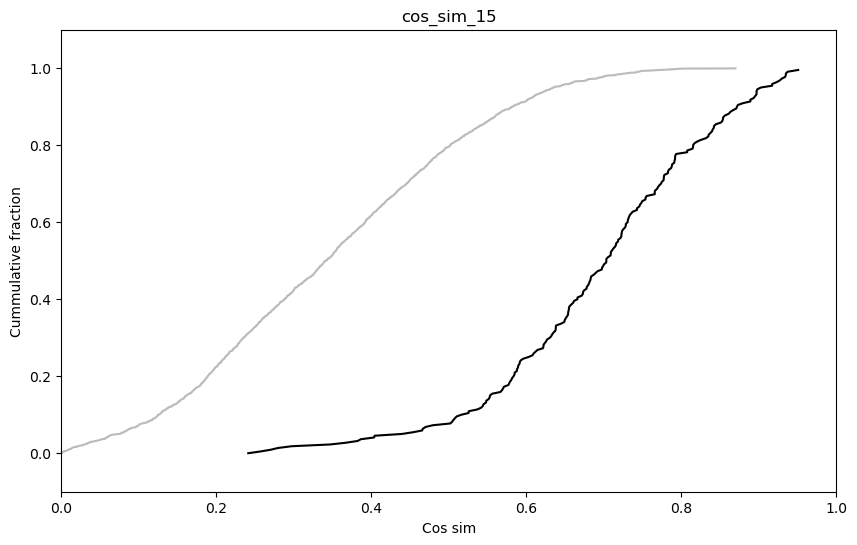

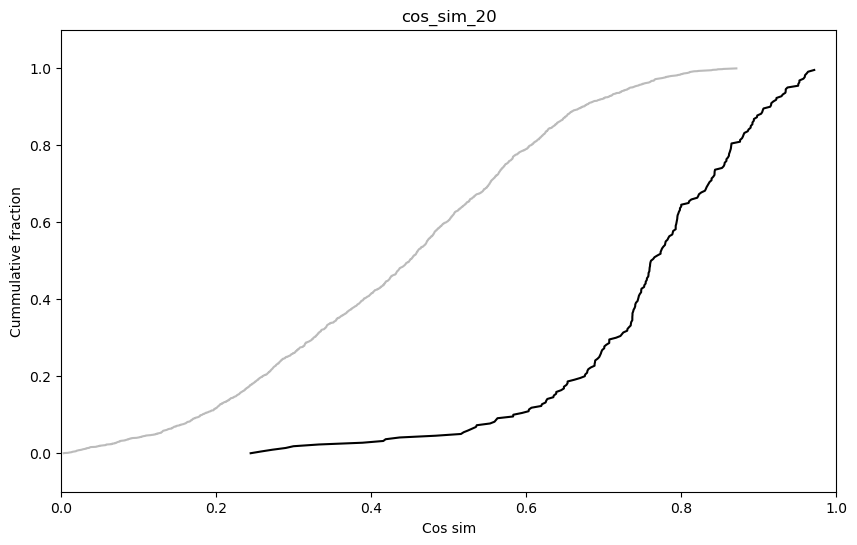

In [74]:
cnt = 0
ks_val = {}
mwu_val = []
dprime_a = []

for d in voxel_d:
    cnt=cnt+1
    idx = 'cos_sim_{}'.format(d)

    # def plot_shuf_cum(x_unsorted,color = '#000000',ref_x=None, fn=None,fignum=4,title=None):
    fig = plt.figure(cnt, figsize=(10, 6))
    ax = plt.subplot()
    ax.set_ylim([-.1, 1.1])
    ax.set_xlim([.945, .96])
    ax.set_xlim([0, 1])
    ax.set_ylabel('Cummulative fraction')
    ax.set_xlabel('Cos sim')
    ax.set_title(idx)

    x_outofpool = sim_compare_df.loc[~sim_compare_df['same_pool'],idx]

    y = np.array(range(len(x_outofpool))).astype(float)/len(x_outofpool)
    ax.plot(sorted(x_outofpool),y,color='#BBBBBB')

    x_inpool = sim_compare_df.loc[sim_compare_df['same_pool'],idx]

    y = np.array(range(len(x_inpool))).astype(float)/len(x_inpool)
    ax.plot(sorted(x_inpool),y,color='#000000')

    fig.savefig('./figpanels/cdf_within_across_{}um_bins.svg'.format(d),format='svg')

    ks_val[d] = scipy.stats.kstest(x_inpool,x_outofpool)
    mwu_out = scipy.stats.mannwhitneyu(x_inpool,x_outofpool)
    mwu_val.append(mwu_out.statistic / (len(x_inpool)*len(x_outofpool)))
    dprime_a.append(np.abs(np.mean(x_inpool)-np.mean(x_outofpool))/np.sqrt((np.var(x_inpool)+np.var(x_outofpool))/2))

    # pct_below_actual = (x_unsorted<ref_x).sum() / len(x_unsorted)
    # p=1-pct_below_actual
    # ax.text(.94,.5,'p = {:.5f}'.format(p))

    # if not fn is None:
    #     fig.savefig('./figpanels/{}.eps'.format(fn),format='eps')

In [75]:
mwu_val

[0.9526426066877619,
 0.9485119302146583,
 0.9509770803044556,
 0.9484819977764475,
 0.9529141366629608,
 0.9406225947147866,
 0.9314397502779441,
 0.9145321987513897]

In [76]:
(len(x_inpool)*len(x_outofpool))

467720

In [78]:
dprime_a

[2.005776338562088,
 2.2510757350560855,
 2.370364807317809,
 2.3800595294660614,
 2.454899920608533,
 2.299438525740808,
 2.169934208447588,
 1.9244656647059004]

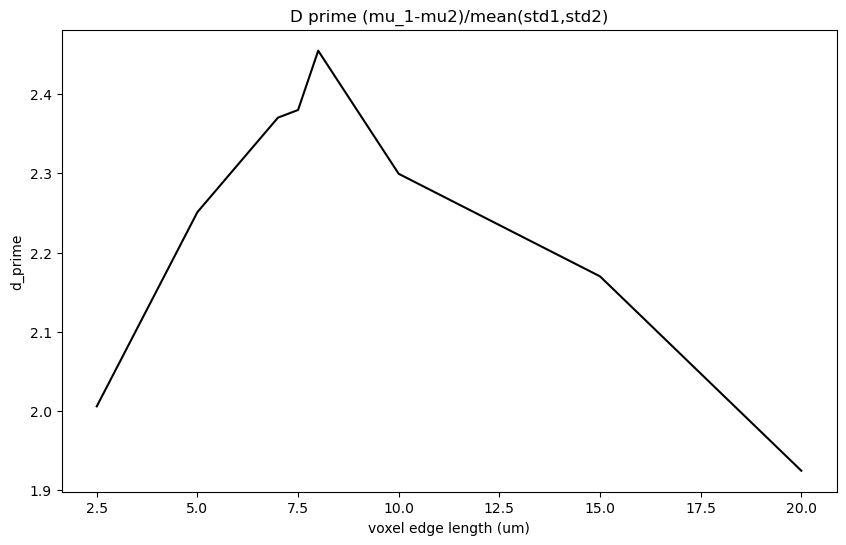

In [79]:
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylabel('d_prime')
ax.set_xlabel('voxel edge length (um)')
ax.set_title('D prime (mu_1-mu2)/mean(std1,std2)')

ax.plot(np.array(voxel_d),np.array(dprime_a),color='#000000')

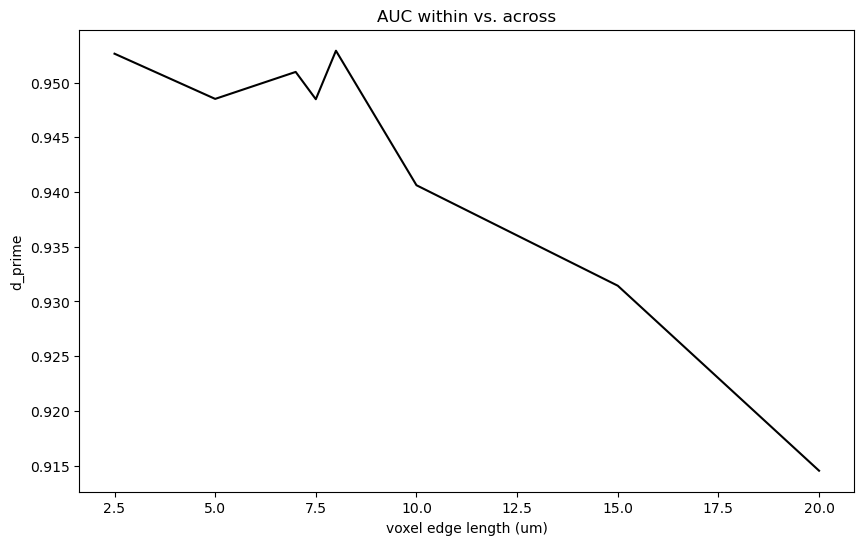

In [80]:
fig = plt.figure(cnt, figsize=(10, 6))
ax = plt.subplot()
ax.set_ylabel('d_prime')
ax.set_xlabel('voxel edge length (um)')
ax.set_title('AUC within vs. across')

ax.plot(np.array(voxel_d),np.array(mwu_val),color='#000000')

In [81]:
mwu_val


[0.9526426066877619,
 0.9485119302146583,
 0.9509770803044556,
 0.9484819977764475,
 0.9529141366629608,
 0.9406225947147866,
 0.9314397502779441,
 0.9145321987513897]

# Other stuff

(array([191.,  14.,   4.,   4.,   4.,   3.,   0.,   0.,   0.,   1.]),
 array([  0. ,  21.4,  42.8,  64.2,  85.6, 107. , 128.4, 149.8, 171.2,
        192.6, 214. ]),
 <BarContainer object of 10 artists>)

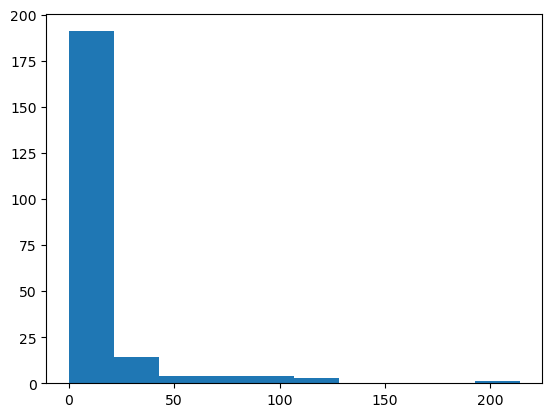

In [82]:
syn_bin_df.loc[:,mnid].max()
plt.hist(syn_bin_df.loc[:,mnid].values)

In [84]:
mpool_dict = utils.get_motor_pool_tuple_dict()
pool_keys = utils.ta_assigned_morpho_pools()
pre_to_mn_df.head()

# new_idx = utils.sort_segment_fcn_index(pre_to_mn_df.columns)
# pre_to_mn_df = pre_to_mn_df[new_idx]

pre_to_mn_df.head()

side                                                                                                                               L  \
nerve                                                                                                                         Dorsal   
segment                                                                                                                       thorax   
function                                                                                                                       swing   
muscle                                                                           tergopleural_promotor_pleural_promotor_miller_28_30   
rank                                                                                                                               0   
segID                                                                                                             648518346487756866   
module                                                                                                                  coxa_promote   
cell_class preferred_pool NT  classification_system cell_type segID                                                                    
descending coxa_promote   NaN NaN                   NaN       648518346493883193                                                  0    
                                                              648518346497743463                                                  0    
                                                              648518346494476087                                                  0    
                                                              648518346507377529                                                  0    
                                                              648518346494232199                                                  0    

side                                                                                                 \
nerve                                                                                                 
segment                                                                                               
function                                                                                              
muscle                                                                                                
rank                                                                                                  
segID                                                                            648518346491659326   
module                                                                                 coxa_promote   
cell_class preferred_pool NT  classification_system cell_type segID                                   
descending coxa_promote   NaN NaN                   NaN       648518346493883193                 17   
                                                              648518346497743463                 42   
                                                              648518346494476087                 13   
                                                              648518346507377529                 12   
                                                              648518346494232199                 11   

side                                                                                                 \
nerve                                                                                                 
segment                                                                                               
function                                                                                              
muscle                                                                                                
rank                                                                                                  
segID                             

In [ ]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline